In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import copy
import warnings
warnings.filterwarnings('ignore')

In [26]:
DEFAULT_CONFIG = {
    # Assets
    "TICKERS": ["SPY", "IWM", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-01-01",
    
    # Crisis Training Periods
    "CRISIS_PERIODS": [
        # ("2007-08-01", "2009-06-01"), # GFC
        ("2018-10-01", "2019-01-01"), # Volmageddon
        ("2020-01-01", "2020-05-01"), # COVID
        ("2022-01-01", "2022-12-31"), # Bear
    ],
    
    # Hyperparameters (To be Optimized)
    "WINDOW_SIZE": 20, 
    "ADX_THRESHOLD": 25,
    "TARGET_VOL": 0.20,
    
    # Fixed Params
    "BB_STD": 2.0,
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 64,
    "TRAINING_STEPS": 50000, 
    "INITIAL_BALANCE": 100000,
    "FEES": 0.0005,
    "BORROW_RATE": 0.0002, 
    "ACTION_SCALER": 5.0,
    "MAX_LEVERAGE": 1.0, 
    "USE_VOL_TARGETING": True,
    "SMA_TREND_FILTER": True,
    "LONG_ONLY": False 
}

In [27]:
class DataProcessor:
    def __init__(self, tickers, config):
        self.tickers = list(set(tickers))
        self.config = config
        
    def download(self, start, end):
        try:
            # Safety check
            if self.config['TARGET_ASSET'] not in self.tickers:
                self.tickers.append(self.config['TARGET_ASSET'])
                
            print(f"Fetching data for: {self.tickers} ({start} to {end})")
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]: data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): 
                data = data.to_frame()
                if self.config['TARGET_ASSET'] not in data.columns:
                    data.columns = [self.config['TARGET_ASSET']]
            
            ohlc = yf.download(self.config['TARGET_ASSET'], start=start, end=end, progress=False)
            return data, ohlc
        except Exception as e:
            print(f"Data Download Error: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def add_features(self, df, ohlc):
        target = self.config['TARGET_ASSET']
        if df.empty or target not in df.columns: return pd.DataFrame()
        
        df = df.copy()
        
        # 1. Base Returns
        df['returns'] = df[target].pct_change()
        
        # 2. Trend (ADX)
        df['tr'] = np.maximum(ohlc['High'] - ohlc['Low'], 
                   np.maximum(abs(ohlc['High'] - ohlc['Close'].shift(1)), 
                              abs(ohlc['Low'] - ohlc['Close'].shift(1))))
        df['dm_plus'] = np.where((ohlc['High'] - ohlc['High'].shift(1)) > (ohlc['Low'].shift(1) - ohlc['Low']), 
                                 np.maximum(ohlc['High'] - ohlc['High'].shift(1), 0), 0)
        df['dm_minus'] = np.where((ohlc['Low'].shift(1) - ohlc['Low']) > (ohlc['High'] - ohlc['High'].shift(1)), 
                                  np.maximum(ohlc['Low'].shift(1) - ohlc['Low'], 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        
        df['di_plus'] = 100 * (df['dp_s'] / df['tr_s'])
        df['di_minus'] = 100 * (df['dm_s'] / df['tr_s'])
        df['dx'] = 100 * abs(df['di_plus'] - df['di_minus']) / (df['di_plus'] + df['di_minus'])
        df['adx'] = df['dx'].rolling(window).mean()
        
        # 3. Mean Reversion
        sma = df[target].rolling(20).mean()
        std = df[target].rolling(20).std()
        df['bb_width'] = (std * 2 * 2) / sma
        df['pct_b'] = (df[target] - (sma - 2*std)) / (4*std)
        
        up = df['returns'].clip(lower=0)
        down = -1 * df['returns'].clip(upper=0)
        ma_up = up.rolling(window).mean()
        ma_down = down.rolling(window).mean()
        rs = ma_up / (ma_down + 1e-9)
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 4. Crisis
        if '^VIX' in df.columns:
            df['vix_norm'] = (df['^VIX'] - 15) / 40
        else:
            df['vix_norm'] = 0
            
        sma200 = df[target].rolling(200).mean()
        df['dist_sma200'] = (df[target] - sma200) / sma200
        
        # 5. Volatility
        df['realized_vol_20d'] = df['returns'].rolling(20).std() * np.sqrt(252)
        df['vol_percentile'] = df['realized_vol_20d'].rolling(252).rank(pct=True)
        
        return df.fillna(0)

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        dfs = []
        for s, e in self.config['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

In [28]:
class TradingEnv(gym.Env):
    def __init__(self, df, config, mode='trend'):
        super(TradingEnv, self).__init__()
        self.df = df
        self.config = config
        self.mode = mode 
        self.n_features = df.shape[1]
        self.window = config['WINDOW_SIZE']
        self.current_step = self.window
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        
        self.data = df.values.astype(np.float32)
        self.cols = df.columns.tolist()
        self.idx_sma = self.cols.index('dist_sma200') if 'dist_sma200' in self.cols else -1

    def reset(self, seed=None, options=None):
        self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        ret = self.data[self.current_step, 0] 
        
        reward = 0
        if self.mode == 'trend':
            # Base Reward: Return
            reward = act * ret * 100
            
            # Trend Guidance: STRICTER
            if self.idx_sma != -1:
                sma_dist = self.data[self.current_step, self.idx_sma]
                # If Price is above SMA (Bullish), PUNISH Shorting
                if sma_dist > 0:
                    if act < 0: reward -= 1.0  # Heavy Penalty for fighting the trend
                    elif act > 0.1: reward += 0.2 # Bonus for being long
                # If Price is below SMA (Bearish), PUNISH Longing
                elif sma_dist < 0:
                    if act > 0: reward -= 1.0
                    elif act < -0.1: reward += 0.2

        elif self.mode == 'mean_rev':
            reward = (act * ret * 100) - (0.1 * abs(act)) 
            
        elif self.mode == 'crisis':
            reward = (act * ret * 100)
            # Crisis Logic: FORCE SHORT BIAS
            if act > 0: 
                reward -= 5.0 # Massive penalty for Longing in a crisis
            if ret < -0.01 and act < -0.5: 
                reward += 2.0 # Huge bonus for catching the crash
            
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

In [29]:
class EnsembleManager:
    def __init__(self, config):
        self.config = config
        self.dp = DataProcessor(config['TICKERS'], config)
        self.agents = {}
        self.envs = {}
        
    def train_specialists(self, verbose=True):
        if verbose: print("\n=== 1. TRAINING SPECIALIST AGENTS ===")
        trend_data = self.dp.get_data(self.config['TRAIN_START'], self.config['TRAIN_END'])
        
        # 1. Trend
        env_trend = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='trend')])
        env_trend = VecNormalize(env_trend, norm_obs=True, norm_reward=False)
        model_trend = PPO("MlpPolicy", env_trend, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_trend.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['trend'] = model_trend
        self.envs['trend'] = env_trend
        
        # 2. Mean Rev
        env_mr = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='mean_rev')]) 
        env_mr = VecNormalize(env_mr, norm_obs=True, norm_reward=False)
        model_mr = PPO("MlpPolicy", env_mr, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_mr.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['mean_rev'] = model_mr
        self.envs['mean_rev'] = env_mr
        
        # 3. Crisis
        crash_data = self.dp.get_crisis_data()
        env_crisis = DummyVecEnv([lambda: TradingEnv(crash_data, self.config, mode='crisis')])
        env_crisis = VecNormalize(env_crisis, norm_obs=True, norm_reward=False)
        model_crisis = PPO("MlpPolicy", env_crisis, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_crisis.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['crisis'] = model_crisis
        self.envs['crisis'] = env_crisis
        
        if verbose: print("=== TRAINING COMPLETE ===\n")

    def run_backtest(self, start_date=None, end_date=None, plot_results=True):
        s_date = start_date if start_date else self.config['TEST_START']
        e_date = end_date if end_date else self.config['TEST_END']
        
        if plot_results: print(f"=== 2. RUNNING BACKTEST ({s_date} to {e_date}) ===")
        
        # Warmup fetch
        warmup_dt = pd.Timestamp(s_date) - pd.Timedelta(days=365)
        full_data = self.dp.get_data(warmup_dt.strftime('%Y-%m-%d'), e_date)
        if full_data.empty: return 0.0
        
        test_indices = np.where((full_data.index >= s_date) & (full_data.index <= e_date))[0]
        if len(test_indices) == 0: return 0.0

        # Execution Loops
        portfolio = self.config['INITIAL_BALANCE']
        holdings = 0
        history = []
        
        # Pre-calc column indices
        cols = full_data.columns.tolist()
        idx_adx = cols.index('adx')
        idx_sma = cols.index('dist_sma200')
        idx_ret = cols.index('returns')
        idx_vol_pct = cols.index('vol_percentile')
        idx_raw_vol = cols.index('realized_vol_20d')
        
        data_vals = full_data.values
        dates = full_data.index
        window = self.config['WINDOW_SIZE']
        
        agent_pnls = {'trend': 0.0, 'mean_rev': 0.0, 'crisis': 0.0}
        
        if plot_results:
            print(f"{'Date':<12} | {'Regime':<10} | {'Active Agent':<10} | {'Raw Act':<8} | {'Scale Act':<10} | {'Balance':<10}")
            print("-" * 90)
        
        for t in test_indices:
            obs_raw = data_vals[t-window : t].flatten()
            
            # Regime Logic
            vol_pct = data_vals[t-1, idx_vol_pct] 
            raw_vol = data_vals[t-1, idx_raw_vol]
            adx = data_vals[t-1, idx_adx]
            sma_dist = data_vals[t-1, idx_sma]
            
            # --- CRITICAL FIX: REGIME SENSITIVITY ---
            # Previous logic was too trigger-happy, causing the Crisis agent (which now forces shorts)
            # to activate during standard pullbacks, destroying the portfolio.
            # We now require DEEP distress to activate Crisis mode.
            
            is_deep_distress = (sma_dist < -0.15) # Price 15% below 200 SMA
            is_vol_panic = (vol_pct > 0.95 and sma_dist < -0.05) # Extreme Vol + Downtrend
            
            if is_deep_distress or is_vol_panic: 
                regime, active_agent_name = "CRISIS", "crisis"
            elif adx > self.config['ADX_THRESHOLD']: 
                regime, active_agent_name = "TREND", "trend"
            else:
                regime, active_agent_name = "CHOP", "mean_rev"
                
            # Predict
            agent = self.agents[active_agent_name]
            norm_env = self.envs[active_agent_name]
            obs_norm = norm_env.normalize_obs(obs_raw)
            action, _ = agent.predict(obs_norm, deterministic=True)
            
            mkt_ret = data_vals[t, idx_ret]
            raw_action = action[0]
            
            # --- FIX: REMOVED HARD GUARDRAILS ---
            # The manual overrides (forcing 0.5 or -0.5) were fighting the trained agents.
            # We rely on the Stricter Regime Detection above and the Agent's own training.
            
            # Volatility Targeting
            vol_scaler = 1.0
            if self.config['USE_VOL_TARGETING'] and raw_vol > 0.01:
                vol_scaler = self.config['TARGET_VOL'] / raw_vol
            vol_scaler = np.clip(vol_scaler, 0.1, 2.0)
            
            # Scaling
            scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler
            
            # Constraints
            if self.config['LONG_ONLY']:
                if active_agent_name == 'crisis':
                     # Crisis agent can short (hedge)
                    scaled_action = np.clip(scaled_action, -10, 10)
                else:
                    # Trend/MeanRev agents are Long Only
                    scaled_action = np.clip(scaled_action, 0, 10)
            
            # Trend Filter
            if self.config['SMA_TREND_FILTER'] and active_agent_name == 'trend':
                if sma_dist < 0: scaled_action = np.clip(scaled_action, -10, 0)
                elif sma_dist > 0: scaled_action = np.clip(scaled_action, 0, 10)
            
            position_size = np.clip(scaled_action, -self.config['MAX_LEVERAGE'], self.config['MAX_LEVERAGE'])
            
            # PnL
            cost = abs(position_size - holdings) * self.config['FEES']
            lev_cost = max(0, abs(position_size)-1) * self.config['BORROW_RATE']
            
            step_pnl_pct = (position_size * mkt_ret) - cost - lev_cost
            step_pnl_dollars = portfolio * step_pnl_pct
            
            portfolio *= (1 + step_pnl_pct)
            holdings = position_size
            
            # Attribute PnL
            agent_pnls[active_agent_name] += step_pnl_dollars
            
            if plot_results and t % 20 == 0: 
                print(f"{str(dates[t].date()):<12} | {regime:<10} | {active_agent_name:<10} | {raw_action:<8.2f} | {position_size:<10.2f} | {portfolio:<10.0f}")
                
            history.append({
                'Date': dates[t],
                'Portfolio': portfolio,
                'Regime': regime,
                'Agent': active_agent_name,
                'Return': step_pnl_pct,
                'Benchmark': mkt_ret,
                'Scale Act': position_size,
                'Trend_PnL': agent_pnls['trend'],
                'MeanRev_PnL': agent_pnls['mean_rev'],
                'Crisis_PnL': agent_pnls['crisis']
            })
            
        res = pd.DataFrame(history).set_index('Date')
        total_ret = (portfolio / self.config['INITIAL_BALANCE']) - 1
        
        if plot_results:
            bench_ret = (1 + res['Benchmark']).cumprod().iloc[-1] - 1
            print(f"\n=== FINAL REPORT: {total_ret:.2%} (Bench: {bench_ret:.2%}) ===")
            self.plot_dashboard(res)
            
        return total_ret
    def plot_dashboard(self, res):
        fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 2, 2, 2]})
        plt.subplots_adjust(hspace=0.2)
        
        # --- Panel 1: Equity & Regimes ---
        res['Bench_Equity'] = (1 + res['Benchmark']).cumprod() * self.config['INITIAL_BALANCE']
        ax0 = axes[0]
        ax0.plot(res.index, res['Portfolio'], label='Ensemble AI', color='black', linewidth=2)
        ax0.plot(res.index, res['Bench_Equity'], label='Buy & Hold', color='gray', linestyle='--', alpha=0.6)
        ax0.set_title(f"Equity Curve: {self.config['TARGET_ASSET']}", fontweight='bold')
        ax0.set_ylabel("Portfolio Value ($)")
        ax0.grid(True, alpha=0.3)
        
        # Regime Shading
        y_min, y_max = ax0.get_ylim()
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'trend'), color='green', alpha=0.1, label='Trend Regime')
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'mean_rev'), color='orange', alpha=0.15, label='Chop Regime')
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'crisis'), color='red', alpha=0.15, label='Crisis Regime')
        ax0.legend(loc='upper left', frameon=True)

        # --- Panel 2: Underwater Plot (Drawdown) ---
        ax1 = axes[1]
        
        # Calculate Drawdowns
        strat_peak = res['Portfolio'].cummax()
        strat_dd = (res['Portfolio'] - strat_peak) / strat_peak
        
        bench_peak = res['Bench_Equity'].cummax()
        bench_dd = (res['Bench_Equity'] - bench_peak) / bench_peak
        
        ax1.fill_between(res.index, strat_dd, 0, color='red', alpha=0.3, label='Strategy Drawdown')
        ax1.plot(res.index, bench_dd, color='gray', linestyle='--', linewidth=1, label='Benchmark Drawdown')
        ax1.set_ylabel("Drawdown %")
        ax1.set_title("Risk Profile: Underwater Plot", fontsize=10)
        ax1.legend(loc='lower left')
        ax1.grid(True, alpha=0.3)

        # --- Panel 3: Agent Contribution (PnL Attribution) ---
        ax2 = axes[2]
        # Calculate raw contribution, not cumulative sum, because we stored cumulative in the loop
        # But stackplot needs layers.
        # Let's plot the cumulative PnL lines for clarity instead of stack
        ax2.plot(res.index, res['Trend_PnL'], label='Trend Agent', color='green', linewidth=1.5)
        ax2.plot(res.index, res['MeanRev_PnL'], label='Mean Rev Agent', color='orange', linewidth=1.5)
        ax2.plot(res.index, res['Crisis_PnL'], label='Crisis Agent', color='red', linewidth=1.5)
        ax2.set_ylabel("Profit Contrib ($)")
        ax2.set_title("Strategy Attribution: Who made the money?", fontsize=10)
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        # --- Panel 4: Exposure Heatmap (Position Size + PnL) ---
        ax3 = axes[3]
        # We plot position size as bars, colored by Daily PnL
        # Normalize returns for colormap: Green=Win, Red=Loss
        colors = ['forestgreen' if r > 0 else 'firebrick' for r in res['Return']]
        
        ax3.bar(res.index, res['Scale Act'], color=colors, width=1.5, label='Exposure (Color=PnL)')
        ax3.axhline(0, color='black', linewidth=0.5)
        ax3.set_ylabel("Exposure (0.0 - 1.0)")
        ax3.set_title("Conviction & Outcome (Green=Win, Red=Loss)", fontsize=10)
        ax3.set_ylim(-0.1, self.config['MAX_LEVERAGE']*1.1)
        ax3.grid(True, alpha=0.3)
        
        # Formatting
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)
        
        plt.savefig(f"backtest_{self.config['TARGET_ASSET']}.png", dpi=300, bbox_inches='tight')
        print(f"Dashboard saved to: backtest_{self.config['TARGET_ASSET']}.png")
        plt.show()

In [30]:
class HyperparameterOptimizer:
    def __init__(self, tickers, target):
        self.tickers = tickers
        self.target = target
        
    def optimize(self, train_start, train_end, val_start, val_end):
        print(f"\n>>> STARTING HYPERPARAMETER OPTIMIZATION FOR {self.target} <<<")
        print(f"    Train: {train_start} to {train_end}")
        print(f"    Valid: {val_start} to {val_end}")
        
        # Grid Search Space
        param_grid = {
            "WINDOW_SIZE": [20, 60],
            "ADX_THRESHOLD": [20, 25],
            "TARGET_VOL": [0.20, 0.40] 
        }
        
        best_ret = -np.inf
        best_config = None
        
        keys, values = zip(*param_grid.items())
        combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
        
        for i, params in enumerate(combinations):
            print(f"Testing Config {i+1}/{len(combinations)}: {params}")
            
            # Create Config Copy
            trial_config = DEFAULT_CONFIG.copy()
            trial_config.update(params)
            trial_config['TICKERS'] = self.tickers
            trial_config['TARGET_ASSET'] = self.target
            trial_config['TRAIN_START'] = train_start
            trial_config['TRAIN_END'] = train_end
            
            # FIX: STRICT VALIDATION SET (No Data Leakage)
            trial_config['TEST_START'] = val_start
            trial_config['TEST_END'] = val_end
            
            # Fast Training
            trial_config['TRAINING_STEPS'] = 10000 
            
            mgr = EnsembleManager(trial_config)
            mgr.train_specialists(verbose=False)
            ret = mgr.run_backtest(plot_results=False)
            
            print(f"  -> Validation Return: {ret:.2%}")
            
            if ret > best_ret:
                best_ret = ret
                best_config = params
                
        print(f"\n>>> BEST PARAMETERS FOUND: {best_config} (Val Ret: {best_ret:.2%}) <<<")
        return best_config


In [31]:
def run_system(tickers, target, start, end, optimize=False):
    config = DEFAULT_CONFIG.copy()
    config['TICKERS'] = tickers
    config['TARGET_ASSET'] = target
    
    # FIX: Updated Defaults to prevent data leakage overlap
    # Training: 2015-2021 | Validation: 2022-2023 | Testing: 2024-Present
    config['TRAIN_START'] = "2015-01-01"
    config['TRAIN_END'] = "2021-12-31" 
    
    config['TEST_START'] = start
    config['TEST_END'] = end
    
    # Safety Defaults for Single Stock
    if target != "SPY":
        config['LONG_ONLY'] = True # This now only applies to Trend/MeanRev agents
        config['MAX_LEVERAGE'] = 1.0
        config['TARGET_VOL'] = 0.40 
        config['ADX_THRESHOLD'] = 20
        config['TRAINING_STEPS'] = 100000 
        
        # CRITICAL RESTORATION: Disable Vol Targeting for Single Stocks to capture full upside
        config['USE_VOL_TARGETING'] = False 
        config['ACTION_SCALER'] = 10.0 

    if optimize:
        # Run optimization on the Validation Period (2022-2023)
        # Distinct from Training (2015-2021) and Testing (2024+)
        opt = HyperparameterOptimizer(tickers, target)
        best_params = opt.optimize(
            train_start="2015-01-01", 
            train_end="2021-12-31", 
            val_start="2022-01-01", 
            val_end="2023-12-31"
        )
        config.update(best_params)
    
    print("\n>>> INITIALIZING FINAL RUN <<<")
    print(f"Config: Window={config['WINDOW_SIZE']}, VolTarget={config['TARGET_VOL']}, ADX={config['ADX_THRESHOLD']}")
    
    mgr = EnsembleManager(config)
    mgr.train_specialists()
    mgr.run_backtest()


>>> STARTING HYPERPARAMETER OPTIMIZATION FOR GOOG <<<
    Train: 2015-01-01 to 2021-12-31
    Valid: 2022-01-01 to 2023-12-31
Testing Config 1/8: {'WINDOW_SIZE': 20, 'ADX_THRESHOLD': 20, 'TARGET_VOL': 0.2}
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2015-01-01 to 2021-12-31)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2018-10-01 to 2019-01-01)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2020-01-01 to 2020-05-01)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2022-01-01 to 2022-12-31)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2021-01-01 to 2023-12-31)
  -> Validation Return: 5.11%
Testing Config 2/8: {'WINDOW_SIZE': 20, 'ADX_THRESHOLD': 20, 'TARGET_VOL': 0.4}
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2015-01-01 to 2021-12-31)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2018-10-01 to 2019-01-01)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2020-01-01 to 2020-05-01)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2022-01-01 to 2022-12-31)
Fetching data for: ['^VIX', 'GOOG', 'SHY'] (2021-01-0

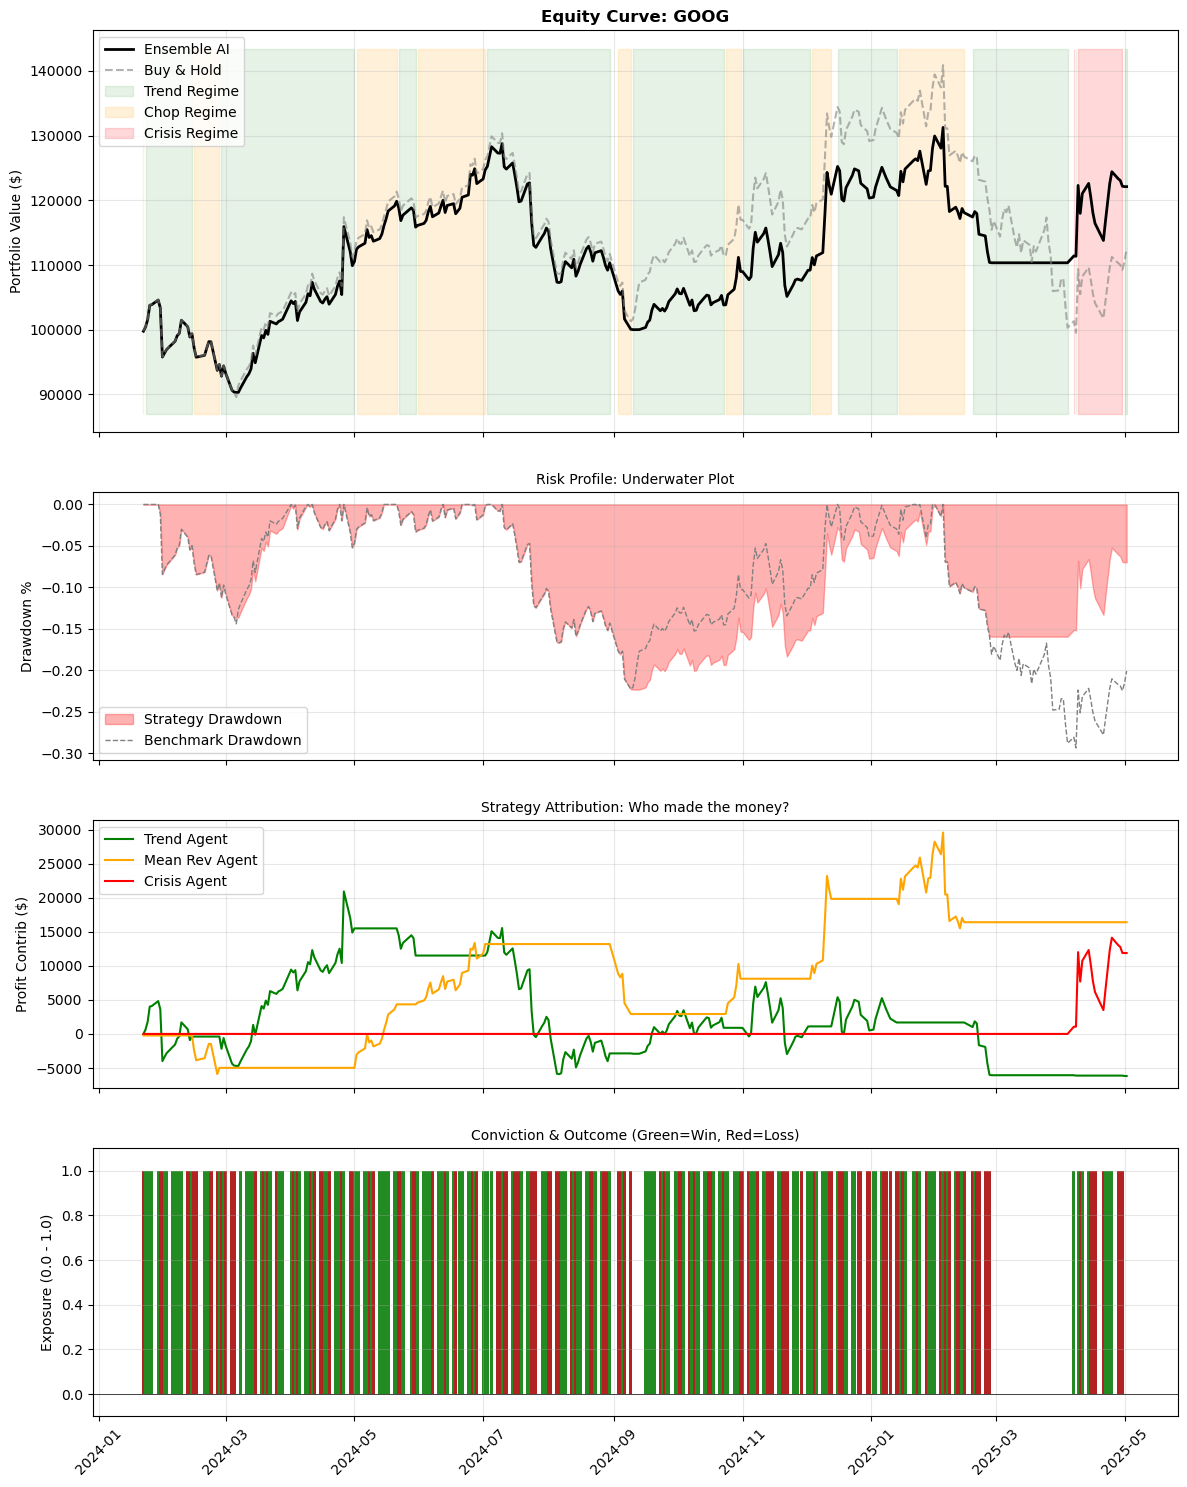

In [33]:
# USER SETTINGS
MY_TICKERS = ["GOOG", "^VIX", "SHY"]
MY_TARGET = "GOOG"
START = "2024-01-22"
END = "2025-05-05"

# Set optimize=True to find best params automatically
run_system(MY_TICKERS, MY_TARGET, START, END, optimize=True)